In [1]:
import sys
sys.path.append('/root/jupyter/Deep_Learning/src/YOLO/')

In [2]:
from keras.models import Model
from keras.utils import Sequence
from keras.layers import Reshape, Input, Activation, Conv2D, GlobalMaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, Lambda, ZeroPadding2D, Dropout, DepthwiseConv2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import cv2
import os

from Yolo_V2_utils import *
from Yolo_V2_extractors import *
from Yolo_V2_preprocessing import *
from Yolo_V2_detection_head import *

%matplotlib inline

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
OBJECT = 'Plate' # Plate / Car / Number
DATASETS = ['GENERATED_DATASET'] # GENERATED, MOROCCAN
BACKEND = 'SqueezeNet' # DarkNet, MobileNet, SqueezeNet

MODEL_SPEC = '{}_{}_{}_Final'.format(OBJECT, BACKEND, '_'.join(DATASETS))

ROOT_DIR = '/root/jupyter/'
DATA_DIR = ROOT_DIR + 'Deep_Learning/data/'
MODEL_DIR = ROOT_DIR + 'Deep_Learning/models/'
BACKEND_DIR = ROOT_DIR + 'Deep_Learning/backends/'

# l'entrainement des extracteurs prend beaucoup de temps, alors j'ai choisi d'utilisée l'apprentissage transféré,
# c-à-d commencer l'entrainement par les poids des structures déja entrainées sur la classification des images 
# dans le concours ImageNet Object Classification.
FULL_YOLO_BACKEND_PATH  = BACKEND_DIR + "yolo_v2.weights"
SQUEEZENET_BACKEND_PATH = BACKEND_DIR + "squeezenet_backend.h5"
MOBILENET_BACKEND_PATH  = BACKEND_DIR + "mobilenet_backend.h5"

TRAIN_VALID_PROP = 0.8
INPUT_SIZE = 320          # maximum width or height
LABELS = [OBJECT]         # Liste des objets que doit YOLO considérer lors de la détection et entrainement
MAX_BOX_PER_IMAGE = 1     # GENERATED 1, MOROCCAN 26
OBJ_THRESH = 0.5          # Valeur minimale de sûreté/fidélité/confidence pour considérer la détéction positive
NMS_THRESH = 0.5          # Valeur minimale de sûreté/fidélité/confidence pour considérer la détéction positive
ANCHORS = [3.73,1.53, 3.87,2.48, 5.19,3.36, 5.80,2.20, 6.39,4.50, 7.56,3.03, 8.33,5.48, 8.72,4.07, 9.03,7.05]

# GENERATED 320 [1.40,0.55, 2.36,0.96, 3.47,1.42, 4.47,1.93, 5.78,2.40, 6.68,3.27, 7.98,2.70, 8.58,3.70, 9.08,4.67]
# GENERATED 640 [2.74,1.10, 4.39,1.83, 6.31,2.65, 8.47,3.61, 11.02,4.59, 12.80,6.18, 15.97,5.34, 16.70,7.28, 18.21,9.28]

# MOROCCAN 1024 [1.61,0.91, 5.37,2.12, 6.37,5.60, 7.61,2.80, 9.20,4.60, 9.89,3.00, 11.66,3.39, 12.68,4.25, 16.94,6.37]
# MOROCCAN 512 [0.74,0.42, 2.28,0.93, 3.22,2.92, 3.61,1.25, 4.13,1.81, 5.12,2.64, 5.30,1.53, 6.14,1.91, 9.07,3.15]

In [4]:
all_imgs, seen_labels = parse_annotation(DATA_DIR, DATASETS)

if INPUT_SIZE < max(all_imgs[0]['width'], all_imgs[0]['height']) :
    print('Check your data input size !!')

train_valid_split = int(TRAIN_VALID_PROP * len(all_imgs))
np.random.shuffle(all_imgs)
valid_imgs = all_imgs[train_valid_split:]
train_imgs = all_imgs[:train_valid_split]

print(seen_labels)

{'Plate': 10000}


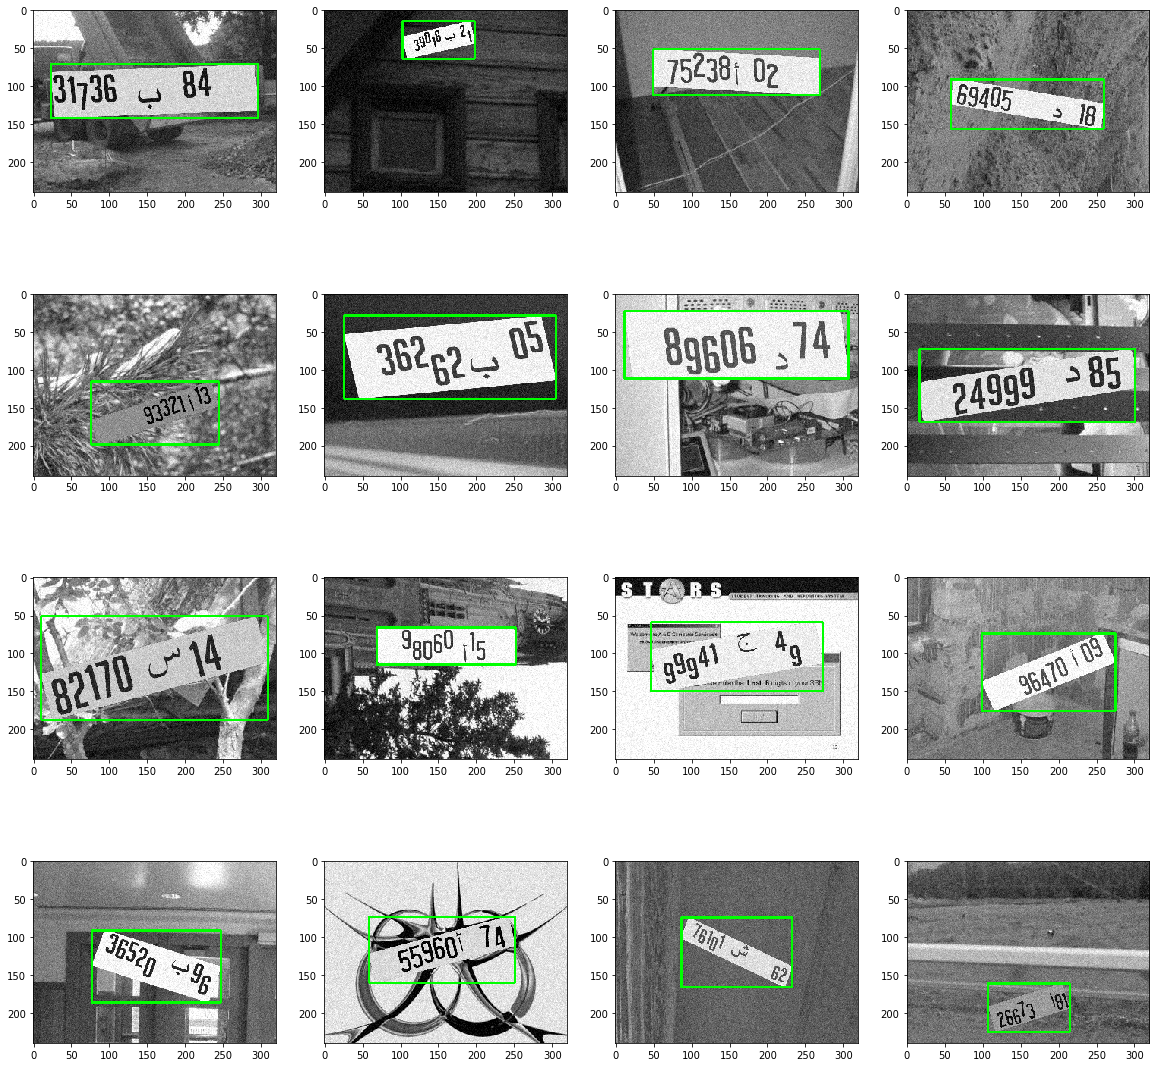

In [5]:
# Visualisation des données

fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    numb = np.random.randint(len(train_imgs))
    rand_img = cv2.imread(train_imgs[numb]['file_name'])
    rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)
    for j in range(len(train_imgs[numb]['object'])) :
        min_labels = (train_imgs[numb]['object'][j]['xmin'], train_imgs[numb]['object'][j]['ymin'])
        max_labels = (train_imgs[numb]['object'][j]['xmax'], train_imgs[numb]['object'][j]['ymax'])
        cv2.rectangle(rand_img, min_labels, max_labels, (0,255,0), 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(rand_img)  
plt.show()

In [6]:
model = YOLO(BACKEND, INPUT_SIZE, LABELS, MAX_BOX_PER_IMAGE, ANCHORS)

(19, 19)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
squeezenet (Model)              (None, 19, 19, 512)  722496      input_1[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 19, 19, 54)   27702       squeezenet[1][0]                 
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 19, 19, 9, 6) 0           DetectionLayer[0][0]             
__________________________________________________________________________________________________
i

In [0]:
model.train(   train_imgs         = train_imgs, # Les images sur lesquelles le model sera entrainé
               valid_imgs         = valid_imgs, # Les images sur lesquelles la performance du model sera validé
               train_times        = 1, # Le nombre de fois pour répéter l'entrainement
               valid_times        = 1, # Le nombre de fois pourrépéter la validation
               nb_epochs          = 100, # Le nombre d'époques
               learning_rate      = 1e-4, # Le taux d'apprentissage initial : \ethat_{0}
               batch_size         = 16, # La taille du batch : Puisqu'on utilise un entrainement par batch
               warmup_epochs      = 3, # Des époques pour l'échauffement permet la familiarisation avec les données
               object_scale       = 5, # Pénalité sur les fausse négative : un objet n'est pas détecté
               no_object_scale    = 1, # Pénalité sur les fausse positive : une détection d'objets inexistant
               coord_scale        = 1, # Pénalité sur les coordonnées du centre de l'objet
               class_scale        = 1, # Pénalité sur les dimensions de l'objet détecté
               saved_weights_name = MODEL_DIR + MODEL_SPEC + '.h5',
               debug              = True)

Epoch 1/100
 25/500 [>.............................] - ETA: 1:02:50 - loss: 14.1709